In [1]:
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import optimizers

from src.cross_validator import AllChannelsCrossValidator
from src.dataset import X_TIME, TIME_STEP, load_dataset_train_test_all_channels
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builders_all_ch as optimal_model_builders
from src.network_utils import plot_difference_hist, gaussian_kernel, count_params

PWD = '../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
PROJECT_NAME = 'compare'

OVERWRITE = False

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
CROSSVAL_DIR = PWD + f'/data/model_selection/channel_all/cross_val'

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 500
BATCH_SIZE = 8096

CROSSVAL_N_CV = 5
CROSSVAL_N_EXEC = 3
LOSS_WEIGHT_REGULAR = 1000
LOSS_WEIGHT_HEATMAP = 1000
LOSS_WEIGHT_DIST = 1000

In [3]:
X_base_train, _, y_base_train, _ = load_dataset_train_test_all_channels(PWD)

X_base_train[(2, 11)].shape, y_base_train[(2, 11)].shape

((22134, 24), (22134,))

In [4]:
y_base_train_heatmap = {key: np.array([gaussian_kernel(y) for y in val]) for key, val in y_base_train.items()}

y_base_train_heatmap[(2, 11)].shape

(22134, 24)

In [5]:
def compile_wrapper(builder, loss_weight):
    def compiled_builder():
        model = builder()
        model.compile(loss='mse', optimizer=optimizers.Adam(LR), loss_weights=loss_weight)
        return model

    return compiled_builder

# Regular models

In [6]:
def regular_metric(y_true, y_pred):
    std, _, _ = plot_difference_hist(y_true, y_pred[:, 0], show=False, close=False)
    return std * 1000  # ps


regular_model_builders = [
    compile_wrapper(optimal_model_builders.mlp, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.convnet, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.rnn, loss_weight=LOSS_WEIGHT_REGULAR),
]
regular_model_names = ['mlp', 'convnet', 'rnn']

cross_validator = AllChannelsCrossValidator(regular_model_builders, list(X_base_train.values()),
                                            list(y_base_train.values()), CROSSVAL_DIR, PROJECT_NAME, n_epochs=N_EPOCHS,
                                            batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA, n_cv=CROSSVAL_N_CV,
                                            n_executions=CROSSVAL_N_EXEC, model_names=regular_model_names,
                                            eval_metric=regular_metric, overwrite=OVERWRITE)

regular_model_scores = cross_validator()

Number of parameters: 3121
Got score: 79.6808 (79.8043, 79.6500, 79.5881)
Got score: 80.7758 (80.7847, 80.8799, 80.6627)
Got score: 79.9873 (79.6471, 80.2440, 80.0707)
Got score: 80.1184 (80.0178, 80.3362, 80.0011)
Got score: 79.5640 (80.1708, 79.1155, 79.4057)


Number of parameters: 44993
Got score: 80.4557 (80.4503, 80.5971, 80.3198)
Got score: 81.2011 (81.3563, 81.2180, 81.0288)
Got score: 80.5003 (80.3644, 80.3481, 80.7885)
Got score: 80.2384 (80.6965, 80.1110, 79.9077)
Got score: 79.7053 (79.7867, 79.8192, 79.5099)


Number of parameters: 50081
Got score: 79.9607 (80.0980, 79.7387, 80.0454)
Got score: 80.7140 (80.7013, 80.6935, 80.7473)
Got score: 80.1087 (80.1446, 80.1246, 80.0570)
Got score: 80.1793 (80.1763, 80.0602, 80.3015)
Got score: 79.7370 (79.7417, 79.6854, 79.7838)


# Heatmap-based models

Number of parameters: 2962785
Got score: 79.6230 (79.7827, 79.5840, 79.5023)
Got score: 80.6845 (80.7721, 80.3485, 80.9328)
Got score: 80.0314 (80.0679, 80.0334, 79.9930)
Got score: 80.1182 (79.8400, 80.3305, 80.1842)


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


Got score: 79.6162 (79.4840, 79.3837, 79.9810)


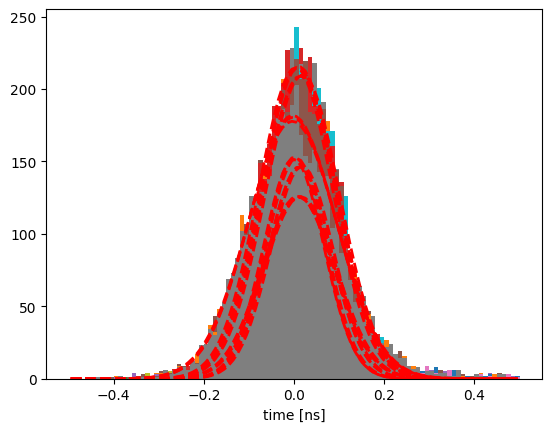

In [7]:
def heatmap_metric(y_heatmap_true, y_heatmap_pred):
    y_true = np.empty(y_heatmap_true.shape[0])
    for i, y in enumerate(y_heatmap_true):
        _, y_true[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    y_pred = np.empty(y_heatmap_pred.shape[0])
    for i, y in enumerate(y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


heatmap_model_builders = [compile_wrapper(optimal_model_builders.unet, loss_weight=LOSS_WEIGHT_HEATMAP)]
heatmap_model_names = ['unet']

cross_validator = AllChannelsCrossValidator(heatmap_model_builders, list(X_base_train.values()),
                                            list(y_base_train_heatmap.values()), CROSSVAL_DIR, PROJECT_NAME,
                                            n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                            n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC,
                                            model_names=heatmap_model_names, eval_metric=heatmap_metric,
                                            overwrite=OVERWRITE)

heatmap_model_scores = cross_validator()

# Comparison

In [8]:
all_model_builders = regular_model_builders + heatmap_model_builders
all_model_names = regular_model_names + heatmap_model_names
all_model_scores = regular_model_scores | heatmap_model_scores

In [9]:
mean_scores = [f"{np.mean(scores):0.2f}" for scores in all_model_scores.values()]
std_scores = [f"{np.std(scores):0.2f}" for scores in all_model_scores.values()]
n_params = [count_params(builder()) for builder in all_model_builders]

df = pd.DataFrame({'mean': mean_scores, 'std': std_scores, 'n_params': n_params}, index=all_model_scores.keys())
df.index.name = 'Model'
df

,mean,std,n_params
Model,,,
mlp,80.03,0.43,3121
convnet,80.42,0.48,44993
rnn,80.14,0.32,50081
unet,80.01,0.39,2962785
